In [52]:
import numpy as np
import os
def read_npy(dir):
    print(dir)
    data = np.load(dir)
    return data

def read_feature(feature_name, label_name):
    root = '/mnt/dataset0/**/workspace/Covariance_EEG_Emotion/visualize'
    feature_dir = os.path.join(root, feature_name)
    label_dir = os.path.join(root, label_name)
    return read_npy(feature_dir), read_npy(label_dir)

def load_sub_average(fea_name, n_sub, set_index):
    fea = np.load(fea_name)
    n_clip_per_sub = fea.shape[0] // n_sub
    fea_avg = fea.reshape(n_sub, n_clip_per_sub, -1).mean(axis=1)
    label_sub = np.arange(n_sub).reshape(-1, 1)
    label_set = np.full_like(label_sub, set_index)
    return fea_avg, label_sub, label_set


In [53]:
fea_names = ['feature_CDA=True/SEED/BALANCED_S1S4S7D_all_fea_epoch=19.ckptme_NOLDS.npy',
             'feature_CDA=True/DEAP/BALANCED_S1S4S7D_all_fea_epoch=19.ckptme_NOLDS.npy']
# fea_names = ['feature_CDA=False/SEED/BALANCED_S1S4S7D_CDA=0_all_fea_epoch=19.ckptme_NOLDS.npy',
#              'feature_CDA=False/DEAP/BALANCED_S1S4S7D_CDA=0_all_fea_epoch=19.ckptme_NOLDS.npy']
n_subs = [15, 32]
data = [load_sub_average(fea_names[i], n_subs[i], i) for i in range(len(fea_names))]
fea = [data_i[0] for data_i in data]
label_sub = [data_i[1] for data_i in data]
label_set = [data_i[2] for data_i in data]
fea = np.concat(fea)
label_sub = np.concat(label_sub)
label_set = np.concat(label_set)

In [54]:
fea.shape

(47, 512)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(fea, label_sub, label_set, title='t-SNE Visualization', 
              random_state=42, perplexity=30, n_iter=1000):
    """
    Visualize features using t-SNE with:
    - Colors representing label_set (same color for same class)
    - Marker shapes representing label_sub (different shapes for different subjects)
    
    Args:
        fea (np.ndarray): Feature array (n_samples, n_features)
        label_sub (np.ndarray): Subject labels (n_samples,) - used for marker shapes
        label_set (np.ndarray): Class labels (n_samples,) - used for colors
        title (str): Plot title
        random_state (int): Random seed for reproducibility
        perplexity (float): t-SNE perplexity parameter
        n_iter (int): Number of iterations for t-SNE
    """
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, 
               perplexity=perplexity, n_iter=n_iter)
    fea_2d = tsne.fit_transform(fea)
    
    # Get unique values
    unique_labels = np.unique(label_set)
    unique_subs = np.unique(label_sub)
    
    # Color and marker setup
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Color by label_set
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4']  # Shape by label_sub
    
    plt.figure(figsize=(10, 8))
    
    # First plot: Color by label_set (create legend entries)
    for i, lbl in enumerate(unique_labels):
        mask = (label_set.flatten() == lbl)
        plt.scatter([], [], c=[colors(i)], label=f'Class {lbl}', alpha=0.7)  # Dummy for legend
    
    # Second plot: Actual points with shapes by subject
    for sub in unique_subs:
        mask = (label_sub.flatten() == sub)
        current_label_set = label_set[mask][0]  # All points from same sub have same label_set
        color_idx = np.where(unique_labels == current_label_set)[0][0]
        
        plt.scatter(fea_2d[mask, 0], fea_2d[mask, 1], 
                   marker=markers[sub % len(markers)],
                   c=[colors(color_idx)],
                   alpha=0.7,
                   edgecolors='w')
    
    # Add separate legend for subject markers
    for sub in unique_subs:  # Show first 5 subjects in legend (adjust as needed)
        plt.scatter([], [], marker=markers[sub % len(markers)], 
                   c='gray', label=f'Sub {sub}', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/home/zqz/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_2555630/4141492551.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Color by label_set
/tmp/ipykernel_2555630/4141492551.py:47: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(fea_2d[mask, 0], fea_2d[mask, 1],
/tmp/ipykernel_2555630/4141492551.py:47: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the

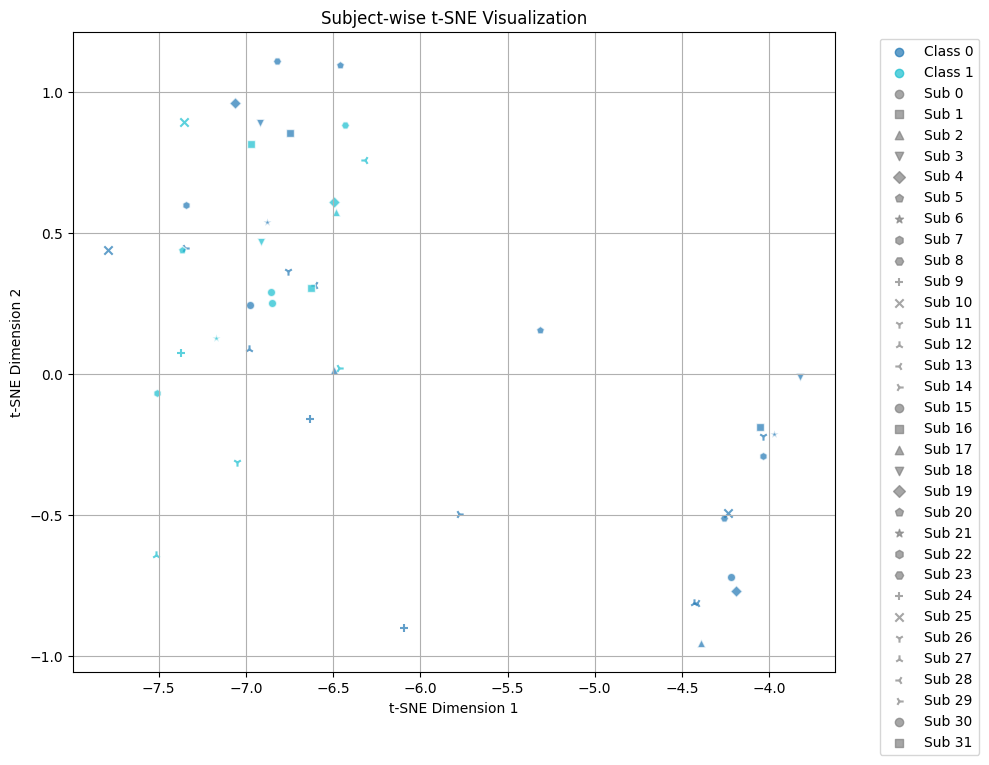

In [56]:
plot_tsne(fea, label_sub, label_set, title='Subject-wise t-SNE Visualization')